In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from sklearn.model_selection import train_test_split
from imblearn.combine import SMOTEENN
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from pure_ldp.frequency_oracles.direct_encoding import DEClient

# Cargar datos
data_path = '../data/raw/bank-full.csv'
df = pd.read_csv(data_path, sep=';')
df['y'] = df['y'].map({'no': 0, 'yes': 1})
X = df.drop(columns=['y'])
y = df['y']

# Mejores parámetros encontrados
best_params_rf = {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

# Crear carpetas para guardar las figuras
figures_base = 'figures'
os.makedirs(figures_base, exist_ok=True)
method = 'Direct_Encoding'
method_path = os.path.join(figures_base, method)
os.makedirs(method_path, exist_ok=True)
subfolders = ['Original'] + [f'eps_{eps}' for eps in [5, 1, 0.5, 0.1]]
for subfolder in subfolders:
    os.makedirs(os.path.join(method_path, subfolder), exist_ok=True)

# Función para mapear variables categóricas binarias y meses
def map_binary_columns(df):
    df['default'] = df['default'].map({'no': 0, 'yes': 1})
    df['housing'] = df['housing'].map({'no': 0, 'yes': 1})
    df['loan'] = df['loan'].map({'no': 0, 'yes': 1})
    df['month'] = df['month'].map({
        'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4,
        'may': 5, 'jun': 6, 'jul': 7, 'aug': 8,
        'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12
    })
    return df

# Función para convertir variables numéricas en categóricas
def convert_numerics_to_categories(df):
    # age
    bins_age = [18, 30, 40, 50, 60, 95]
    labels_age = ['18-30', '31-40', '41-50', '51-60', '61+']
    df['age'] = pd.cut(df['age'], bins=bins_age, labels=labels_age, include_lowest=True)

    # balance
    bins_balance = [-8019, 0, 72, 448, 1428, 102127]
    labels_balance = ['negative', '0-72', '73-448', '449-1428', '1429+']
    df['balance'] = pd.cut(df['balance'], bins=bins_balance, labels=labels_balance, include_lowest=True)

    # day
    bins_day = [1, 7, 14, 21, 31]
    labels_day = ['1-7', '8-14', '15-21', '22-31']
    df['day'] = pd.cut(df['day'], bins=bins_day, labels=labels_day, include_lowest=True)

    # duration
    bins_duration = [0, 103, 180, 319, 4918]
    labels_duration = ['0-103', '104-180', '181-319', '320+']
    df['duration'] = pd.cut(df['duration'], bins=bins_duration, labels=labels_duration, include_lowest=True)

    # campaign
    bins_campaign = [1, 2, 3, 10, 63]
    labels_campaign = ['1', '2-3', '4-10', '11+']
    df['campaign'] = pd.cut(df['campaign'], bins=bins_campaign, labels=labels_campaign, include_lowest=True)

    # pdays
    bins_pdays = [-1, 0, 30, 90, 871]
    labels_pdays = ['no_contact', '0-30', '31-90', '91+']
    df['pdays'] = pd.cut(df['pdays'], bins=bins_pdays, labels=labels_pdays, include_lowest=True)

    # previous
    bins_previous = [0, 1, 2, 5, 275]
    labels_previous = ['0', '1-2', '3-5', '6+']
    df['previous'] = pd.cut(df['previous'], bins=bins_previous, labels=labels_previous, include_lowest=True)

    return df

# Función para mapear variables categóricas a valores numéricos
def map_categorical_columns(df, categorical_columns):
    mappings = {}
    for col in categorical_columns:
        # Convert to string to handle categorical types and handle NaN
        df[col] = df[col].astype(str).replace('nan', pd.NA)
        unique_values = sorted(df[col].dropna().unique())
        mappings[col] = {value: idx for idx, value in enumerate(unique_values)}
        df[col] = df[col].map(mappings[col])
    return df, mappings

# Función para aplicar DE con Direct Encoding
def apply_de(df, epsilon, categorical_columns, cat_mappings):
    df_de = df.copy()
    for col in categorical_columns:
        d = len(cat_mappings[col])
        de = DEClient(epsilon=epsilon, d=d)
        df_de[col] = df_de[col].apply(lambda x: min(max(de.privatise(int(x)), 0), d-1) if pd.notna(x) else x)
    return df_de

# Función para generar matrices de conteo (heatmaps) de feature vs target
def plot_feature_target_count_matrices(X_original, X_privatized, y, categorical_columns, cat_mappings, method, model_name):
    # Ensure y is a Series with the same index as X_privatized
    df_privatized = X_privatized.copy()
    df_privatized['y'] = y.reset_index(drop=True)

    for col in categorical_columns:
        # Skip if column has all NaN values
        if df_privatized[col].isna().all():
            print(f"Skipping {col}: all values are NaN")
            continue

        # Create a reverse mapping to convert indices back to categories
        reverse_mapping = {idx: cat for cat, idx in cat_mappings[col].items()}
        
        # Convert the privatized indices back to category labels
        df_privatized[col] = df_privatized[col].map(reverse_mapping)
        
        # Check for NaN values after mapping
        if df_privatized[col].isna().any():
            print(f"Warning: NaN values found in {col} after mapping. Filling with 'Unknown'")
            df_privatized[col] = df_privatized[col].fillna('Unknown')

        # Create count matrix
        count_matrix = pd.crosstab(df_privatized['y'], df_privatized[col])
        
        # If count_matrix is empty, skip this feature
        if count_matrix.empty:
            print(f"Skipping {col}: count matrix is empty")
            continue

        # Ensure all categories are present
        categories = list(cat_mappings[col].keys())
        if 'Unknown' in df_privatized[col].values:
            categories = categories + ['Unknown']
        count_matrix = count_matrix.reindex(columns=categories, fill_value=0)
        
        # Ensure the index is set correctly
        if len(count_matrix) == 1:
            # If only one class is present, add the other with zeros
            if 0 in count_matrix.index:
                count_matrix.loc[1] = 0
            else:
                count_matrix.loc[0] = 0
            count_matrix = count_matrix.sort_index()
        count_matrix.index = ['y=0', 'y=1']

        # Create heatmap
        plt.figure(figsize=(max(6, len(categories) * 0.5), 3))
        sns.heatmap(count_matrix, annot=True, fmt='d', cmap='Blues', cbar_kws={'label': 'Count'})
        plt.title(f'Count Matrix: {col} vs Target ({method}, {model_name})')
        plt.xlabel(f'{col} Categories')
        plt.ylabel('Target (y)')
        plt.tight_layout()
        filepath = os.path.join('figures', method, model_name, f'count_matrix_{col}.png')
        plt.savefig(filepath, dpi=300, bbox_inches='tight')
        plt.close()

# Procesamiento completo
def process_data(X, y, categorical_columns, cat_mappings, apply_DE=False, epsilon=None):
    x = X.copy()
    if apply_DE and epsilon:
        x = apply_de(x, epsilon, categorical_columns, cat_mappings)

    # One-Hot Encoding (OHE)
    x = pd.get_dummies(x, columns=categorical_columns, drop_first=True, dtype='int64')

    # Split train-test
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

    # Aplicar SMOTEENN para balancear clases
    smoteenn = SMOTEENN(random_state=42)
    X_train_resampled, y_train_resampled = smoteenn.fit_resample(X_train, y_train)

    # Selección de características con Boruta
    rf = RandomForestClassifier(**best_params_rf, random_state=42)
    boruta = BorutaPy(rf, n_estimators='auto', verbose=0)
    boruta.fit(X_train_resampled.values, y_train_resampled.values)
    selected_features = X_train_resampled.columns[boruta.support_].tolist()
    return X_train_resampled[selected_features], X_test[selected_features], y_train_resampled, y_test

# Entrenar y evaluar modelo
def evaluate_model(X_train, y_train, X_test, y_test):
    model = RandomForestClassifier(**best_params_rf, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    conf_matrix = confusion_matrix(y_test, y_pred)
    actual_negatives, actual_positives = conf_matrix[0].sum(), conf_matrix[1].sum()
    false_positive_pct = conf_matrix[0][1] / actual_negatives if actual_negatives > 0 else 0
    false_negative_pct = conf_matrix[1][0] / actual_positives if actual_positives > 0 else 0
    return {
        'ROC AUC': roc_auc_score(y_test, y_prob),
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'Type I Error': false_positive_pct,
        'Type II Error': false_negative_pct
    }

# Todas las columnas son ahora categóricas
all_categorical_columns = ['default', 'housing', 'loan', 'job', 'marital', 'education', 'contact', 'poutcome',
                           'age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

# Epsilons y resultados
epsilons = [5, 1, 0.5, 0.1]
results = {}

# Preprocesar datos originales
X_original = X.copy()  # Guardar copia de los datos originales para heatmaps
X = map_binary_columns(X)
X = convert_numerics_to_categories(X)
X, cat_mappings = map_categorical_columns(X, all_categorical_columns)


In [8]:

# Generar heatmaps para datos originales
print("Generando matrices de conteo para datos originales...")
plot_feature_target_count_matrices(X_original, X, y, all_categorical_columns, cat_mappings, 'Direct_Encoding', 'Original')

# Modelo sin privacidad
X_train, X_test, y_train, y_test = process_data(X, y, all_categorical_columns, cat_mappings)
results['Original'] = evaluate_model(X_train, y_train, X_test, y_test)

# Modelos con Direct Encoding y generación de heatmaps
for epsilon in epsilons:
    print(f"Generando matrices de conteo para Direct Encoding (ε={epsilon})...")
    X_de = apply_de(X.copy(), epsilon, all_categorical_columns, cat_mappings)
    plot_feature_target_count_matrices(X_original, X_de, y, all_categorical_columns, cat_mappings, 'Direct_Encoding', f'eps_{epsilon}')
    
    X_train_de, X_test_de, y_train_de, y_test_de = process_data(X_de, y, all_categorical_columns, cat_mappings)
    results[f'DE (ε={epsilon})'] = evaluate_model(X_train_de, y_train_de, X_test_de, y_test_de)


Generando matrices de conteo para datos originales...
Generando matrices de conteo para Direct Encoding (ε=5)...
Generando matrices de conteo para Direct Encoding (ε=1)...
Generando matrices de conteo para Direct Encoding (ε=0.5)...
Generando matrices de conteo para Direct Encoding (ε=0.1)...


               Original  DE (ε=5)  DE (ε=1)  DE (ε=0.5)  DE (ε=0.1)
ROC AUC        0.859433  0.858763  0.673636    0.662339    0.645116
Accuracy       0.765777  0.741964  0.412341    0.368770    0.303966
Precision      0.311800  0.295396  0.146690    0.137594    0.131334
Recall         0.818523  0.859199  0.827910    0.827284    0.874218
F1 Score       0.451579  0.439641  0.249223    0.235945    0.228361
Type I Error   0.241267  0.273692  0.643156    0.692462    0.772188
Type II Error  0.181477  0.140801  0.172090    0.172716    0.125782


<Figure size 1200x600 with 0 Axes>

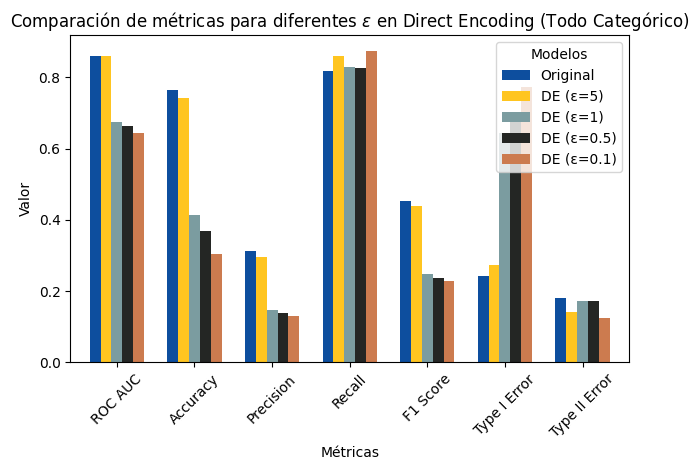

In [9]:

# Resultados
results_df = pd.DataFrame(results)
print(results_df)

# Gráficas
colores = ['#0d4e9e', '#ffc520', '#7b9ca0', '#242624', '#cc7b4f']
plt.figure(figsize=(12, 6))
ax = results_df.plot(kind='bar', width=0.7, color=colores)
plt.title('Comparación de métricas para diferentes $\epsilon$ en Direct Encoding (Todo Categórico)')
plt.xlabel('Métricas')
plt.ylabel('Valor')
plt.xticks(rotation=45)
plt.legend(title='Modelos')
plt.tight_layout()
plt.show()